# Data Analysis of energy consumption patterns


## Abstract

Understanding energy consumption patterns is vital in an industry, that of the distribution of electrical energy, which is very much limited by infrastructural capacity. The electric network, in fact, must be sized by taking into account "worst-case" utilisation scenario: the network cannot collapse if there is a sudden surge in demand. Serving users during period of peak demand, however, is very expensive and reduces the network capability of absorbing systemic demand variations.

For these reasons, in the last years there has been a big push in understanding the demand patterns of different type of commercial and residential users, to be able to predict when the demand will be higher. By appropriate pricing, then, the operator can try to shift some of the load from periods of high demand to period of low demand, thereby balancing the load on the network.

Using an open big dataset of hourly measurement of electric consumption over the course of one year, we will try to derive demand patterns which can be used as input for pricing strategies. The data refers to users in the United States, over the year 2004, and is available on the OpenEI website.

## Introduction


With this notebook we will explore a big dataset, containing hourly measures of energy consumption in a wide variety of buildings, both commercial and residential. The data is relative to the United States during year 2004.

## Setting up the notebook

We first take care of some technicalities. The following directive tells Jupyter to show plots in-line in this document:

In [1]:
%matplotlib inline

Next, we are going to import our data analysis library, `pandas`. Since we are going to write `pandas` all the time, we shorten it to `pd` for brevity:

In [2]:
import pandas as pd

We also import the `pyplot` library, which will be very useful to visualise our data with charts and plots.

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In the next snippet we define a function, `timeparser`, which will convert our columns "date" and "time" into a Python `datetime` object. It basically tells Python in which format our "date" and "time" columns are.

In [4]:
timeparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')

We are ready to read the data. We will merge the columns "date" and "time" into a single column "datetime", using the parser function `timeparser` that we defined above.

In [5]:
df = pd.read_csv('energy-consumption.csv', parse_dates = {'datetime': ['date', 'time']}, date_parser = timeparser)

## Getting a first flavour of the data

We start with some simple task. The first thing we might want to know is how does the total energy profile looks like in an average day. This means that we want to consider both residential and commercial buildings of all types, and we do not discrimnate between weekdays and weekends.
This graph is simple to produce, but perhaps not so informative: in reality there is no such thing as an *average* building or an *average* day.

Since we would like to have a plot with the **hour of the day** on the x-axis and the **energy consumption** on the y-axis, we first add a column to our dataset, which extracts the hour of the day from the "datetime" columns:

In [6]:
df['hour'] = df['datetime'].apply(lambda x: x.hour)

Then, getting the average (or *mean*) energy usage, by hour is as simple as running a `groupby` query on our dataset. Notice that, since "energy" is the only numeric column we have, `pandas` understand that it has to take the mean of that column only, and that "energy" contains the values we want to plot.

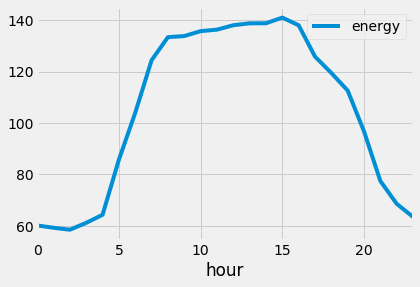

In [7]:
df.groupby('hour').mean().plot()

Unsurprisingly, the graph tells us that the energy consumption is lower at night and higher during the day, with a peak at around 16:00.
Let's get some more detail, producing two graphs now: one for commercial and one for residential buildings.

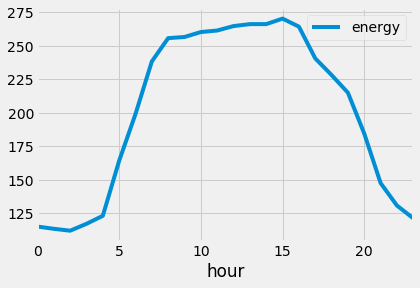

In [8]:
df[df.category == 'commercial'].groupby('hour').mean().plot()

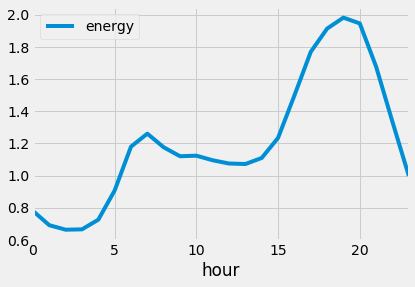

In [9]:
df[df.category == 'residential'].groupby('hour').mean().plot()

The situation is already more interesting here. The first thing we can notice is that commercial buildings consume much more energy than residential ones. At the lowest, they consume around 110kW/h and have peaks of more than 270kW/h. Residential buildings, on the other hand, have a consumption in the range from 0.6 to 2.0kW/h.

This explains why the first "overall" graph and the second "commercial-only" have a similar shape (commercial consumption dominates), but different values on the y-axis (due to averaging with the very low residential values).

Also notice that the shape of the consumption curve is totally different for residential buildings: they have a first peak around 07:00, when people wake up, and then a larger peak at 18:00-21:00, when most people come back home from work.

Another thing we can do is to plot, instead of the *average* energy consumption, the *total* one, i.e. the sum of all consumptions. Since there is a big difference in magnitude between the consumptions of commercial and residential buildings, we expect this plot to ave a shape similar to the residential one and - in fact - this is the case:

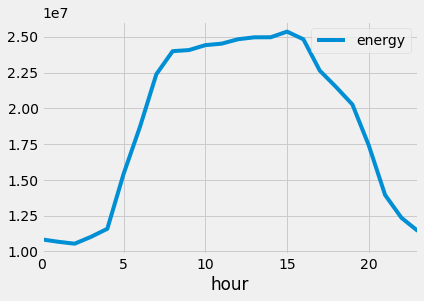

In [10]:
df.groupby('hour').sum().plot()

## Further exploration 1: individual buildings

Next we might try to get some more insight on the hourly consumption. Instead of plotting the average among all the buildings of a certain type, we can plot the consumption of **each individual building**. To avoid the plot becoming a huge mess, we use the same colour for all buildings, and we set the opacity of each indivdual line to 1% (meaning that we need 100 superimposed lines to make a black mark).

Because we might want the same type of graph for many different building types, we create a function:

In [11]:
def multiline_hourly_plot(dataset, avg = None, ycol = 'energy', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()

Let's now have a look at this type of chart, for residential buildings:

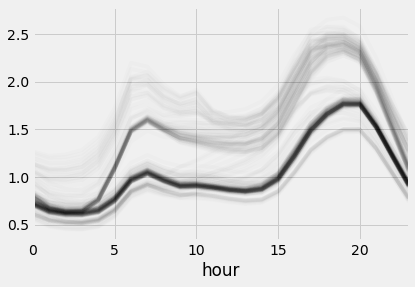

In [12]:
multiline_hourly_plot(df[df.category == 'residential'].groupby('name'))

We can already see something that we could not notice by just looking at the averages: there is a certain profile which is followed by most buildings (the lower, thicker curve) and a higher-energy profile followed by fewer buildings (the top, fainter curve).

Let's do the same with the commercial buildings. Notice that a commercial building is identified by both its type and its name.

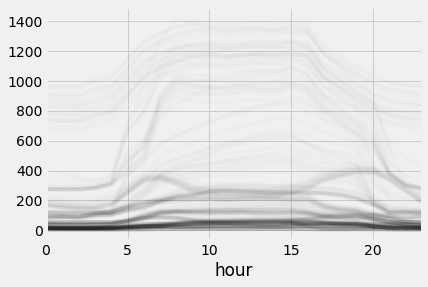

In [13]:
multiline_hourly_plot(df[df.category == 'commercial'].groupby(['type', 'name']))

Well, this is really not so informative: since there are a few high-consumption buildings with peaks of up to 1300kW/h, the majority of other buildings look flattened down in the bottom part of the graph. Not all visualisations are **good visualisations**!

Let's zoom in, by only showing lines below 400kW/h:

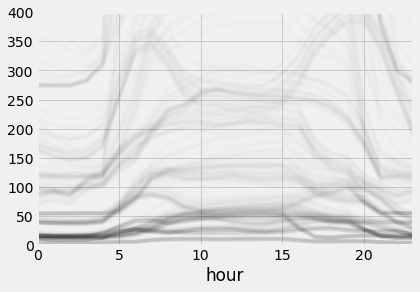

In [14]:
multiline_hourly_plot(df[df.category == 'commercial'].groupby(['type', 'name']), ymax = 400)

Here we can see more clearly two characteristics of these data: there are different scales, and different patterns.

For the first problem, the solution is easy, we could simply **normalise the data** by recording, for each building, its peak consumption, and then expressing the other value as a fraction of the peak value.

The second problem, instead, seems to suggest that a **clustering algorithm** is needed, in order to divide the buildings into "energy usage categories".

We will tackle both problems, but let's first play with the data some more!

## Further exploration 2: individual days

Let's now try to have a look at one particular building, and make a multilineplot with one line for each **day of the year**. To this end, we are going to need a "day of the year" column in the data:

In [15]:
df['day'] = df['datetime'].apply(lambda x: x.timetuple().tm_yday)

We extract the data for the building we are interested in. In this case, we look for a fast-food restaurant in Atlanta, Georgia (USA).

In [16]:
bld_df = df[(df.category == 'commercial') & (df.type == 'QuickServiceRestaurant') & (df.name == 'GA_ATLANTA')]

We can then reuse our handy function `multiline_hourly_plot` to have our plot:

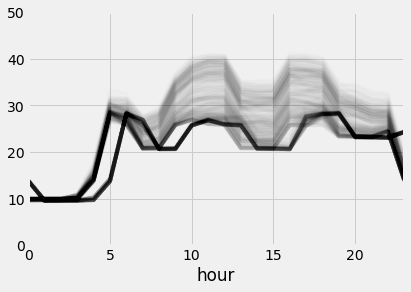

In [17]:
multiline_hourly_plot(bld_df.groupby('day'), ymax = 50)

Now, this is interesting. First of all, as we can expect, we have three peaks during the day: breakfast, lunch, and dinner. These peaks, however, and the breakfast peak in particular, are somehow "doubled".

My hypothesis is that the later peak corresponds to **weekends**, when people get out of home later and have their meals later, so restaurants open later. Let's see if this makes sense, by plotting weekdays and weekends individually.

In order to do this, we need to add a column to the dataset, recording whether a day is a weekday or a weekend:

In [18]:
df['weekday'] = df['datetime'].apply(lambda x: x.weekday() < 5)

Now, let's only plot for weekdays (Mon-Fri):

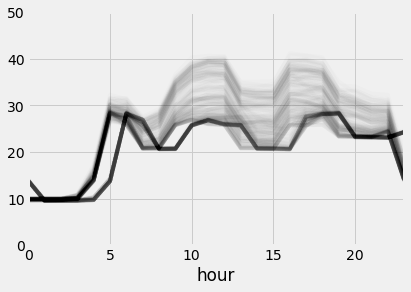

In [19]:
# We need to redefine bld_df because we added a new column to df...
# this was not automatically "imported" into bld_df
bld_df = df[(df.category == 'commercial') & (df.type == 'QuickServiceRestaurant') & (df.name == 'GA_ATLANTA')]
multiline_hourly_plot(bld_df[bld_df.weekday == True].groupby('day'), ymax = 50)

Ops, it looks like the **hypothesis was wrong**. Great we could figure that out with just one line of code!

Ok, what could the reason be... let's check if there is any particular day of the week in which the pattern looks different. From the figure we can discriminate the two patterns by looking at the energy consumption at 05:00. In one series, this is at around 30kW/h, in the other it is at around 15kW/h.

So, let's filter those records for which the consumption at 05:00 is above 20kW/h and count how many of them happen in each day of the week:

In [20]:
df_5 = bld_df[(bld_df.hour == 5) & (bld_df.energy < 20)]
import calendar # To have human-readable names for the days of the week
df_5['datetime'].apply(lambda x: calendar.day_name[x.weekday()]).value_counts()

Thursday     19
Saturday     18
Monday       18
Tuesday      18
Wednesday    18
Friday       18
Sunday       17
Name: datetime, dtype: int64

As we can see, there is no relevant difference in the pattern between the days of the week. The hunt continues!

Let's see, is there any particular time of the year when our schedules are suddenly pushed forward by one hour? Wait a minute, yes! It's when we change to **Dailight Saving Time** (and back)! Could this be the explanation?

Let's find out. Let's print the weeks of the year for which there are days with the pattern we are looking for:

In [21]:
wk_5 = df_5['datetime'].apply(lambda x: x.isocalendar()[1]).value_counts().keys().tolist()
wk_5.sort()
wk_5

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 45, 46, 47, 48, 49, 50, 51, 52, 53]

Here we go! We get a neat list of contiguous weeks. Let's check which days the two extreme weeks (11 and 45) corresponded to, in 2004:

In [22]:
print(pd.datetime.strptime('2014 11 Mon', '%Y %W %a'), " --- ", pd.datetime.strptime('2014 11 Sun', '%Y %W %a'))
print(pd.datetime.strptime('2014 45 Mon', '%Y %W %a'), " --- ", pd.datetime.strptime('2014 45 Sun', '%Y %W %a'))

2014-03-17 00:00:00  ---  2014-03-23 00:00:00
2014-11-10 00:00:00  ---  2014-11-16 00:00:00


So the second pattern only occured between the beginning of the year and the end of March, and the beginning of November and the end of the Year. This roughly corresponds to the time of the year when we are not on DST!

Great, so now we know that we might have to **fix our data** to take into account DST. But is this observation valid for that particular fast food restaurant in Atlanta only? Let's test the hypothesis over all buildings.

## Checking the data for errors

We will plot, in this case, the average hourly consumption over all buildings, but divided in two series, corresponding to DST and non-DST. So, first of all, let's add a column that says if a measurement corresponds to a DST time.

In [23]:
from geopy import geocoders # For matching the buildings' cities with time zones
from geopy.exc import GeocoderTimedOut # Catch timeouts while using Google geocoding API
from geopy.exc import GeocoderUnavailable # Catch other network problems
from datetime import datetime # For date/time calculations
import time # For sleeping
import pytz # For timezones

# g = geocoders.GoogleV3() # A geocoder to transform a citiy's name into lat/lng

# First, we extract the state and city name from the building name
df['state'] = df['name'].apply(lambda x: x.split('_')[0])
df['city'] = df['name'].apply(lambda x: x.split('_', 1)[1].replace('_', ' ').title())

In [24]:
# Then we calculate the time zones for each city
tz_info = {}

# To avoid exhausting the free resources available via the Google API,
# we use it only once and save the result on a text file. All subsequent
# times we simply read from the textfile.
import os.path

tzfile = 'timezones.csv'
if os.path.isfile(tzfile):
    # Read from file (quick)
    with open(tzfile, 'r') as f:
        for line in f:
            city, tz, lat, lng = line.strip().split(',')
            tz_info[city] = {'tz': pytz.timezone(tz), 'lat': lat, 'lng': lng}

# Use Google API (slow) and write to file (for next time)
with open(tzfile, 'a') as f:
    for key, group in df.groupby(['state', 'city']):
        state = key[0]
        city = key[1]
        
        if city in tz_info:
            continue
        
        while True:
            try:
                place, (lat, lng) = g.geocode(city + ', ' + state + ', USA')
                tz = g.timezone((lat, lng))
                tz_info[city] = {'tz': tz, 'lat': lat, 'lng': lng}
                f.write(city + ',' + str(tz) + ',' + str(lat) + ',' + str(lng) + '\n')
                print('.', end = '', flush = True) # Writes a dot to show that it is progressing
                time.sleep(1)
            except (GeocoderTimedOut, GeocoderUnavailable):
                time.sleep(3)
                continue
            break

In [25]:
# This function tells us if a time is in DST
is_dst = lambda t: t.dst().total_seconds() > 0

# This function gets the localised datetime for a dataset row
get_localtime = lambda row: tz_info[row['city']]['tz'].localize(row['datetime'])

# Add the DST field
df['dst'] = df.apply(lambda row: is_dst(get_localtime(row)), axis = 1)

We are now ready to generate the plots we are interested in. Let's start from residential buildings:

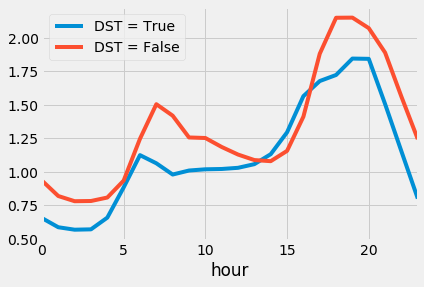

In [26]:
fig, ax = plt.subplots()

for dst in [True, False]:
    data = df[(df.category == 'residential') & (df.dst == dst)].groupby('hour').mean()
    ax = data.plot(ax = ax, y = 'energy', label = 'DST = ' + str(dst))

plt.show()

Indeed, we can see that the yellow and blue curve are "shifted" (look, for example, at the morning peak). But we can also see something else, which is perhaps not so surprising: in winter (DST = `False`) the average energy consumption is higher than in summer (DST = `True`).

Let's now look at commercial buildings:

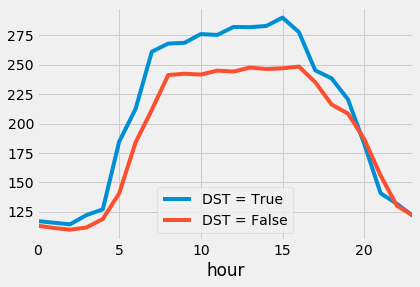

In [27]:
fig, ax = plt.subplots()

for dst in [True, False]:
    data = df[(df.category == 'commercial') & (df.dst == dst)].groupby('hour').mean()
    ax = data.plot(ax = ax, y = 'energy', label = 'DST = ' + str(dst))

plt.show()

Here we notice the same shift, except that it looks like in commercial buildings the energy consumption is higher in summer, pehaps due to the massive use of air conditioning that is standard in the U.S.?

## Fixing the data

Fixing the data is going to be easy. With a couple of lines of code we can account for the DST shift. We will add a column `adj_energy` which will give the adjusted energy consumption, taking into account the time shift.

In [28]:
df['shift_energy'] = df['energy'].shift(1)
df['adj_energy'] = df.apply(lambda row: row['shift_energy'] if row['dst'] else row['energy'], axis = 1)

Let's now print the last two plots again, to verify that this time there is no shift:

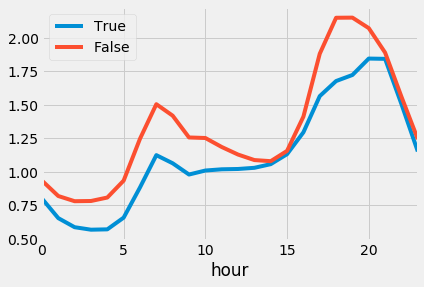

In [29]:
fig, ax = plt.subplots()

for dst in [True, False]:
    ax = df[(df.category == 'residential') & (df.dst == dst)].groupby('hour').mean().plot(ax = ax, y = 'adj_energy', label = str(dst))

plt.show()

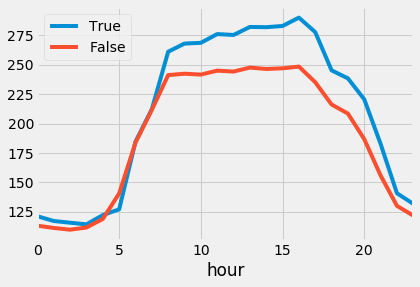

In [30]:
fig, ax = plt.subplots()

for dst in [True, False]:
    ax = df[(df.category == 'commercial') & (df.dst == dst)].groupby('hour').mean().plot(ax = ax, y = 'adj_energy', label = str(dst))

plt.show()

Indeed, it looks like we have been succesful in our quest to data fixing! Finally, we remove the temporary column `shift_energy` that we created above:

In [31]:
del df['shift_energy']

## Data normalisation

As mentioned before, we would like to cluster the buildings in our dataset, based on the energy consumption pattern. One of the biggest problem for an electric power network infrastrucutre manager, in fact, is the presence of peak demand. For the interested readers, these Wikipedia pages explain why peaks are so "dangerous" for a healthy infrastructure:

* [Peak demand](https://en.wikipedia.org/wiki/Peak_demand)
* [Energy demand management](https://en.wikipedia.org/wiki/Energy_demand_management)
* [Load balancing (electrical power)](https://en.wikipedia.org/wiki/Load_balancing_%28electrical_power%29)

With a clustering of the buildings based on their consumption patterns, it is possible to reduce peaks by proposing diversified pricing schemes to the users. For example, we could offer better prices for off-peak consumption, with the hope that the user will shift some of its load to different hours. This, of course, is not always possible: a restaurant cannot really ask its customers to show up earlier or later. But sometimes, it is an effective strategy: in a household, for example, we can decide to do the laundry or turn on the dishwasher at a different time.

Because we are only interested in consumption patterns and not in the magnitude of the consumption, the first thing to do is to normalise the data. For each building, we record the yearly highest measurement and give it a value of 1. All other measurements will then be mapped to values in the interval `[0.0, 1.0]`. Let's see how to do it with Pandas.

First of all, we add a column which will store the maximum energy used by each building during the year. Since we have many rows for each building, there will be a lot of duplicate values in this column, but this is not a problem. 

In [32]:
df['max_energy'] = df.groupby(['category', 'type', 'name'])['adj_energy'].transform(max)

Next, we simply divide the energy consumption by the respective maximum, thereby creating a new column with the **normalised energy** consumption, `norm_energy`.

In [33]:
df['norm_energy'] = df['adj_energy'] / df['max_energy']

## Clustering: which features to use?

We are now ready for the core *machine-learning* part of our task: clustering the buildings according to their energy consumption pattern.

We have all the energy readings available. 24 readings a day for 365 days sums up to 8760 possible features. This is clearly too much. As a first approximation, we can start aggregating the yearly consumption hour-by-hour, and see what happens.

We could also try to use the `city` and `state` features, to see if they lead to better results. For an explanation of why this could help, see the next section.

## Clustering: validation

How do we validate that the clustering we obtain makes sense? My idea is that the building types can give us a hint. It is indeed not unreasonable to think that there is one energy consumption pattern for each building type, and therefore looking at this characteristic is enough to classify buildings.

In any case, we would expect that building type and consumption pattern are quite related. For example, for each building type, we expect that all the buildings of that type fall into one or possibly two clusters. If this is the case, we could reinforce our confidence in the proposed approach.

Another feature that probably influences the consumption patterns is the building's state and city. It is quite likely that being in different locations has an impact on the energy consumption pattern. We would expect a home in Alaska and Texas to have at least some difference in their daily energy usage. Since there are many different cities in our dataset, it is probably best to "consolidate" the previous observation into a single (possibly numeric) parameter. My proposal is to use the building's latitude as a proxy for the "climate" zone it belongs to. We will later check whether or not this proposal is sound.

Notice that, ultimately, it is our problem-specific knowledge that comes into play. There is no general, problem-agnostic way to decide which features are relevant, and which to use for validation. We are not even sure that the proposal we made are good: at any point we should be ready to challenge these choices and, in case, change strategy.

## Clustering: summary

In short we will try to:
* Try clustering with the following features:
    * Average consumption at each hour of the day (24 features);
    * State (1 feature? we will see)
    * City (1 feature? we will see)
* Try to replace the `state` and `city` columns with a numeric proxy, `lat`itude.
* Try clustering again, only using the average hour-by-hour consumption.

## Clustering: which algorithm to use?

For our clustering, we are going to use the "*go-to*" algorithm for clustering problems: **$k$-Means**. This is, somehow, the default clustering algorithm one should choose, unless there is a good motivation for choosing otherwise.

With $k$-Means clustering we aim at dividing $n$ observations $x_1, \ldots, x_n$ into $k$ clusters $C_1, \ldots, C_k$, so to minimise the within-cluster sum of square distances:
$$\sum_{i = 1}^k \sum_{x \in C_i} \| x - \mu_i \|$$
where $\mu_i$ is the centroid of cluster $C_i$, i.e. the component-wise mean of the points in the centroid.

The problem of finding the clusters in $\mathcal{NP}$-complete, but good heuristics exist, which most of the time find local optima very close to the global optimum.

One problem with $k$-Means is that the parameter $k$ must be given as an input. We, however, do not know how to estimate a good number of clusters. Optimally, we would like to minimise both (a) the number of clusters and (b) the average variance of the clusters. Of course a trivial way to minimise (b) is to choose one cluster for each data point, i.e. choosing the maximum possible number of clusters. Not so good! The more the number of clusters is small, the more variance there will be in each of them. Ultimately, we will have to accept a trade-off between these two quantities.

An accepted rule for choosing $k$ consists in trying clustering with many different values of $k$ and drawing a *Pareto-optimal* frontier where the two directions are (a) and (b), this latter expressed as the intra-cluster sum of square distances. To choose the "best" $k$, one looks at the curve constituting the Pareto-optimal frontier, and tries to find an inflexion point: for all smaller values of $k$ we increase the variance too much, and for all larger ones, the variance does not decrease too much. That will be our *sweet spot*. This method is known as the **elbow method**. The following picture is a screenshot from [Andrew Ng's Coursera course](https://www.coursera.org/learn/machine-learning/lecture/Ks0E9/choosing-the-number-of-clusters):
![Elbow Method](elbow.png)

## Clustering with $k$-Means

So, let's get ready for $k$-Means clustering, by starting to import some useful Python packages:

In [34]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import cluster 

Next, we prepare our data by reducing the dataset to the components we are interested in. Furthermore, we create one component (column) for each hour of the day, and aggregate in order to take the average hourly consumption over all days of the year.

In [35]:
red_df = df[['category', 'type', 'state', 'city', 'day', 'hour', 'norm_energy']]
piv_df = pd.pivot_table(red_df, index = ['category', 'type', 'state', 'city', 'day'], columns = 'hour', values = 'norm_energy')
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby(['category', 'type', 'state', 'city']).mean()
grp_df.reset_index(inplace = True)
del grp_df['day'] # This feature is not relevant any more

Here, however, we hit the first roadblock: $k$-Means works by considering the distance between two points. But two points of our dataset could look like this:
$$(\text{AZ},\text{Phoenix},0.456,0.468,\ldots)$$
$$(\text{CA},\text{Los Angeles},12,0.12,0.119,\ldots)$$
While the last 24 components are **numeric**, the first two components are **categorical**, i.e. elements of discrete non-numeric sets. In order to compute the distance, we need to transform these components into numeric components.

An extablished method for doing so is to introduce, for each categorical feature, $P$ components. Here $P$ is the number of different discrete values that the feature can have. But how many equivalent features are we going to have?

In [36]:
df['city'].unique().size

232

In [37]:
df['state'].unique().size

50

Wow, that's quite a lot, and it could make our clustering efforts much harder. But let's not take the umbrella before it rains. For now we use this "brute-force" method and see what happens. Fortunately Pandas has a built-in method that does this for us: `get_dummies`.

In [38]:
kmeans_df = pd.get_dummies(grp_df, columns = ['state', 'city'])

Next, we write a function that implements the elbow method: we are going to try various values of $k$ and plot the intra-cluster variation as a function of $k$:

In [39]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

Here we are, ready to experiment and see if we get a nice picture, like the one of Andrew Ng. Notice that we drop the columns `category` and `type` here because we do not want to use them as features for $k$-Means, but we do not remove them completely, because they are needed to reconstruct, after running the algorithm, which building belonged to which cluster.

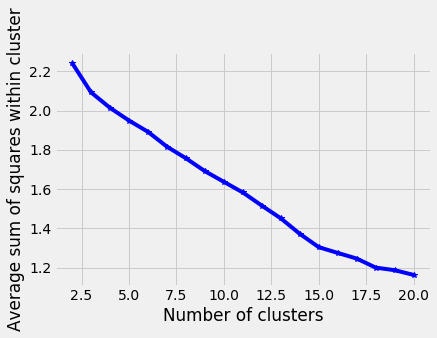

In [40]:
k_algs, k_res = elbow_method(kmeans_df.drop(['category', 'type'], axis = 1), 2, 20)

Ops! This is quite bad. Not only we don't have an elbow, but we also have strange jumps in the curve. Of course the clustering method is a heuristic, so we are not guaranteed that the optimal clusters have been found, but I think it's more likely that our excessive number of features is messing up the algorithm. After all we are using quite a number of features, aren't we?

In [41]:
kmeans_df.columns.size - 2 # Minus 2 because 'category' and 'type' were not used for k-Means

306

Yes, that's definitely too many. Ok, we need to come up with something clever to get rid especially of the `state` and `city` features, which constitute the majority of components of our input space. The idea of having them was to mostly differentiate between different climates. However, a good proxy for how warm or cold a certain place is on average, is it's distance from the equator... in other words, its latitude.

## Reducing the numbers of features

My proposal is to add a new `lat` column, and use that (which is already conveniently numerical) *in lieu* of `city` and `state`:

In [42]:
df['lat'] = df['city'].apply(lambda city: float(tz_info[city]['lat'])) # Use float() or lat will be a string
max_lat = df['lat'].max()
min_lat = df['lat'].min()

In [43]:
df['norm_lat'] = (df['lat'] - min_lat) / (max_lat - min_lat)

In [44]:
red_df = df[['category', 'type', 'name', 'norm_lat', 'day', 'hour', 'norm_energy']]
piv_df = pd.pivot_table(red_df, index = ['category', 'type', 'name', 'norm_lat', 'day'], columns = 'hour', values = 'norm_energy')
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby(['category', 'type', 'name', 'norm_lat']).mean()
grp_df.reset_index(inplace = True)
del grp_df['day'] # This feature is not relevant any more

In [45]:
kmeans_df = grp_df

We should now have a reasonable amount of features:

In [46]:
kmeans_df.columns.size - 3 # Minus 3 because 'category', 'type' and 'name' are not used for k-Means

25

Twenty-five (`lat` plus one for each hour of the day). It is certainly looking better than 296. But if we try to apply the Elbow method, are we going to have a more reasonable picture? Let's find out!

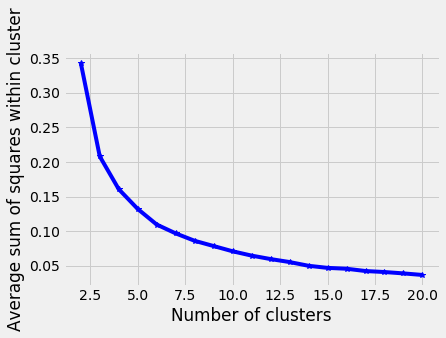

In [47]:
k_algs, k_res = elbow_method(kmeans_df.drop(['category', 'type', 'name'], axis = 1), 2, 20)

Ok, this at least looks like the picture we whished to have. My qualitative evaluation is that this picture is showing an optimal $k$ value of 6. Let's have a look at the clusters we have found.

In [48]:
algorithm = k_algs[4] # Values of k are {2, 3, 4, 5, ..., 20} so k = 6 corresponds to the element with index 4
clustering = k_res[4]

Here we can print the cluster centres, in the expanded coordinates:

In [49]:
clustering.cluster_centers_

array([[ 0.38214653,  0.16613338,  0.16548168,  0.1649841 ,  0.16489209,
         0.16549502,  0.17600679,  0.24264282,  0.30046547,  0.42428232,
         0.48281102,  0.50582363,  0.51894324,  0.52323772,  0.54309175,
         0.55007838,  0.5551854 ,  0.54520968,  0.44231409,  0.37271582,
         0.35672988,  0.33011516,  0.22140537,  0.17120882,  0.16799819],
       [ 0.44120256,  0.30294102,  0.25891862,  0.23994994,  0.23678612,
         0.24223158,  0.27586024,  0.35569028,  0.44135635,  0.41691269,
         0.37403763,  0.37227575,  0.36895385,  0.36067456,  0.35369172,
         0.35528082,  0.37977793,  0.45559359,  0.58157288,  0.65177319,
         0.66591646,  0.68531187,  0.65693899,  0.53727411,  0.41820003],
       [ 0.3883174 ,  0.36248008,  0.29866655,  0.2866578 ,  0.28621249,
         0.30508608,  0.40758828,  0.64315103,  0.70766882,  0.65662237,
         0.60586122,  0.60988333,  0.62792342,  0.62805524,  0.59618248,
         0.56610217,  0.57177039,  0.63224001,  0

To obtain something more informative, let's call the `predict` method with the same dataframe as a parameter. This will give a list with one entry for each (aggregate) row, i.e. one entry for each building. The entry itself is the cluster number associated with that building.

In [50]:
cls_list = algorithm.predict(kmeans_df.drop(['category', 'type', 'name'], axis = 1))

Let's add it as a column to our aggregate dataset, so we can use it to query our data as we want.

In [51]:
kmeans_df['cluster'] = cls_list

In [52]:
def print_building_types_in_clusters(data):
    for tp in data['type'].unique():
        print('How many buildings of type', tp, 'are in each cluster?')
        print(data[data.type == tp]['cluster'].value_counts())

In [53]:
print_building_types_in_clusters(kmeans_df)

How many buildings of type FullServiceRestaurant are in each cluster?
2    16
Name: cluster, dtype: int64
How many buildings of type Hospital are in each cluster?
3    16
Name: cluster, dtype: int64
How many buildings of type LargeHotel are in each cluster?
2    16
Name: cluster, dtype: int64
How many buildings of type LargeOffice are in each cluster?
5    14
0     2
Name: cluster, dtype: int64
How many buildings of type MediumOffice are in each cluster?
0    10
4     5
5     1
Name: cluster, dtype: int64
How many buildings of type MidriseApartment are in each cluster?
1    15
2     1
Name: cluster, dtype: int64
How many buildings of type OutPatient are in each cluster?
5    16
Name: cluster, dtype: int64
How many buildings of type PrimarySchool are in each cluster?
0    16
Name: cluster, dtype: int64
How many buildings of type QuickServiceRestaurant are in each cluster?
2    16
Name: cluster, dtype: int64
How many buildings of type SecondarySchool are in each cluster?
0    15
5     1


This look very reasonable, as there are entire building type which belong to exactly one cluster: this is something we would expect, given how much the usage pattern is correlated with the building purpose.
We can have a better view of these information in tabular form:

In [54]:
def make_cluster_table(data):
    tbl = data[['type', 'cluster']]
    tbl_grp = tbl.groupby(tbl.columns.tolist(), as_index = False).size()
    # tbl_frm = tbl_grp.to_frame().reset_index()
    tbl_frm = tbl_grp
    tbl_frm.columns = ['type', 'cluster', 'count']
    tbl_pvt = pd.pivot_table(tbl_frm, index = 'type', columns = 'cluster', values = 'count').fillna(0).astype(int)
    return (tbl_frm, tbl_pvt)

In [55]:
tbl_frm, tbl_pvt = make_cluster_table(kmeans_df)
tbl_pvt

cluster,0,1,2,3,4,5
type,,,,,,
FullServiceRestaurant,0,0,16,0,0,0
Hospital,0,0,0,16,0,0
LargeHotel,0,0,16,0,0,0
LargeOffice,2,0,0,0,0,14
MediumOffice,10,0,0,0,5,1
MidriseApartment,0,15,1,0,0,0
OutPatient,0,0,0,0,0,16
PrimarySchool,16,0,0,0,0,0
QuickServiceRestaurant,0,0,16,0,0,0


Or we can visualise the results with a scatter plot. We put the sixteen types on the $y$-axis, and the five clusters on the $x$-axis.

In [56]:
from matplotlib.ticker import MaxNLocator

def cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['type'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['count'])
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq)
    plt.show()

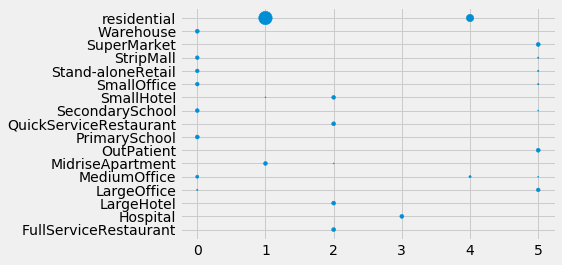

In [57]:
cluster_scatter_plot(tbl_frm)

The size of the dot represents the number of buldings in the cluster. However, since the *residential* `category` only has one `type`, the residential dots are the biggest and it is difficult to ascertain the size of the other dots. Let then the dot size represent the share of building of a certain type assignet to the cluster.

In [58]:
def compute_building_share(original_df, kmeans_df, tbl_frm):
    bld_share = {}
    for tp in original_df['type'].unique():
        tot_num_buildings = len(original_df[original_df.type == tp].groupby('name'))
        bld_share[tp] = {}
        for c in kmeans_df['cluster'].unique():
            nb = tbl_frm[(tbl_frm.type == tp) & (tbl_frm.cluster == c)]['count']
            if not nb.empty:
                bld_share[tp][c] = int(nb) / tot_num_buildings
    return bld_share

In [59]:
bld_share = compute_building_share(df, kmeans_df, tbl_frm)
tbl_frm['bld_pct'] = tbl_frm.apply(lambda row: bld_share[row['type']][row['cluster']], axis = 1)

In [60]:
def norm_cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['type'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['bld_pct'].apply(lambda x: x * 100))
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq);

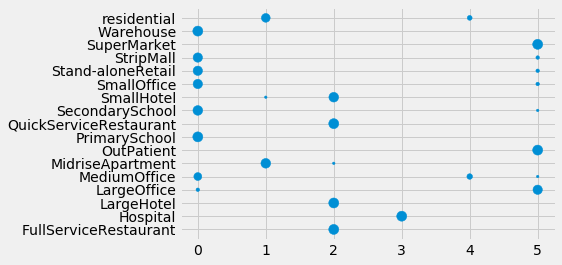

In [61]:
norm_cluster_scatter_plot(tbl_frm)

What can we notice?
* Most residential buildings are in a cluster with buildings from the other types which looks most similar to a residential building: `MidriseApartment`.
* Another, smaller, part of residential building is in another cluster with medium offices.
* Hospitals are in a category of their own (possibly because of their different requirements, e.g. keeping some machines turned on 24h per day, etc.).
* The other bulidings are split between clusters... and it's hard to see what these buildings have in common, by just looking at the above scatter plot.

In order to get more insights, let's plot the energy profiles of buildings in each cluster.

In [62]:
def clusters_visualisation(kmeans_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
    clusters = kmeans_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

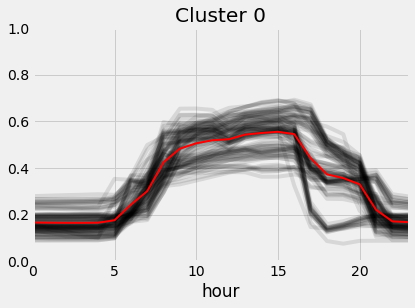

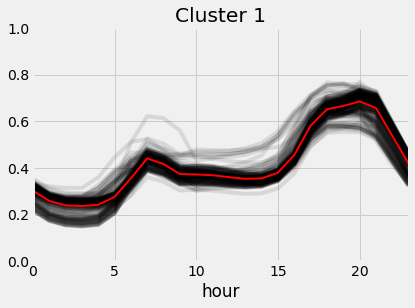

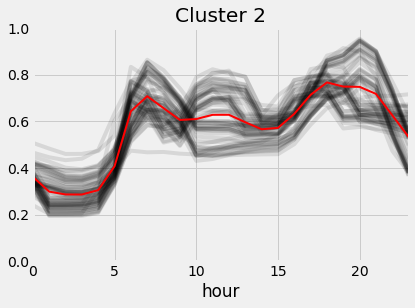

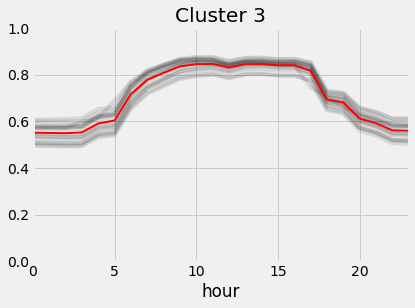

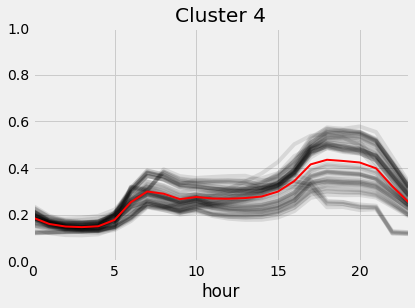

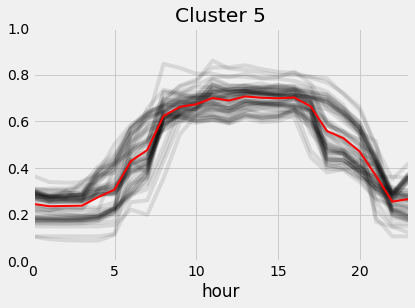

In [63]:
clusters_visualisation(kmeans_df, id_vars = ['category', 'type', 'name', 'cluster'], value_vars = list(kmeans_df.columns[4:28]))

Here the red lines represent the average consumption among all the buildings belonging to the cluster. We can notice a few interesting things:
* Some buildings have higher energy consumption between 7:00 and 19:00, but even at night their consumption is at around 60% of the peak. It turns out, by looking at the table above, that these are hospitals.
* Some buildings have 3 peaks: the highest at around 20:00, another one at around 07:00-08:00, and a smaller one at around 12:00-14:00. These are restaurants and hotels.
* Some buildings have quite uniform consumption between 07:00 and 18:00, and very low consumption during night hours. These are big offices, supermarkets, and buildings marked as "*OutPatient*" (I am not able to figure out what this name means).
* Some buildings also have a uniform consumption, mostly between 07:00 and 17:00, with a small decrease between 12:00 and 13:00. These are warehouses, retailers, schools, and small/medium offices. Places where possibly there is an "almost-simultaneous" launch-break.
* Residential buildings and "*MidriseApartments*" belong to a cluster of their own. They are both characterised by two peaks (one at 07:00-08:00, and one at 18:00-20:00).

## Focussing on commercial buildings

Residential buildings seem to have quite predictable patterns, characterised by two peaks. On top of this, a residential building is easy to detect for the energy provider, as residential and commercial customers are on completely different contracts. This is the reason why many energy providers have started since the 90's to offer reduced energy prices for night-time consumption to household customers, to push them to e.g. use their dishwashers and washing machines in the late evening.

It could, then, make sense to repeat our analysis focussing only on buildings belonging to the `commercial` category. Let's see what might happen:

In [64]:
cm_red_df = df[df.category == 'commercial'][['type', 'name', 'norm_lat', 'day', 'hour', 'norm_energy']]
cm_piv_df = pd.pivot_table(cm_red_df, index = ['type', 'name', 'norm_lat', 'day'], columns = 'hour', values = 'norm_energy')
cm_piv_df.reset_index(inplace = True)
cm_grp_df = cm_piv_df.groupby(['type', 'name', 'norm_lat']).mean()
cm_grp_df.reset_index(inplace = True)
del cm_grp_df['day'] # This feature is not relevant any more
cm_kmeans_df = cm_grp_df

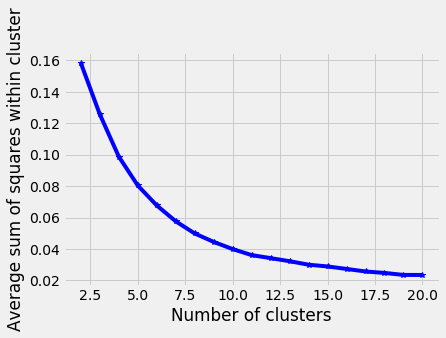

In [65]:
cm_k_algs, cm_k_res = elbow_method(cm_kmeans_df.drop(['type', 'name'], axis = 1), 2, 20)

The elbow method again suggests that 6 is a sensible choice for $k$. Lets' see...

In [66]:
if 'cluster' in cm_kmeans_df.columns.tolist():
    del cm_kmeans_df['cluster']

cm_algorithm = cm_k_algs[4] # Values of k are {2, 3, 4, 5, ..., 20} so k = 4 corresponds to the element with index 4
cm_clustering = cm_k_res[4]
cm_cls_list = cm_algorithm.predict(cm_kmeans_df.drop(['type', 'name'], axis = 1))
cm_kmeans_df['cluster'] = cm_cls_list

In [67]:
cm_tbl_frm, cm_tbl_pvt = make_cluster_table(cm_kmeans_df)
cm_tbl_pvt

cluster,0,1,2,3,4,5
type,,,,,,
FullServiceRestaurant,0,0,16,0,0,0
Hospital,16,0,0,0,0,0
LargeHotel,0,0,16,0,0,0
LargeOffice,0,5,0,11,0,0
MediumOffice,0,1,0,0,0,15
MidriseApartment,0,0,0,0,16,0
OutPatient,0,0,0,16,0,0
PrimarySchool,0,1,0,0,0,15
QuickServiceRestaurant,0,0,16,0,0,0


Let's once more plot the scatter plot:

In [68]:
cm_bld_share = compute_building_share(df, cm_kmeans_df, cm_tbl_frm)
cm_tbl_frm['bld_pct'] = cm_tbl_frm.apply(lambda row: cm_bld_share[row['type']][row['cluster']], axis = 1)

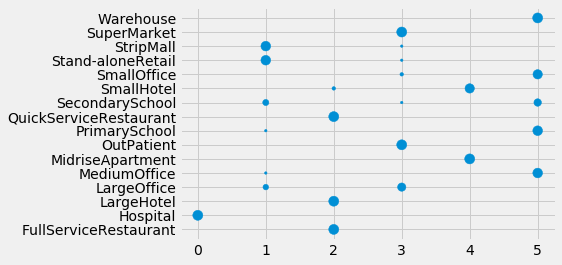

In [69]:
norm_cluster_scatter_plot(cm_tbl_frm)

Here, again, we can see something interesting:

* Hospitals get once more a cluster of their own.
* The two building types we might expect being more similar to a residential building (small hotels and midrise apartments) are, indeed, clustered together.
* Schools, warehouses, and medium offices are grouped together, perhaps because these are places where people normally have a lunch break (or turn shift) all at the same time?
* Restaurants (and large hotels, which are likely to have restaurants) are also grouped all together.

Let's plot the clusters to see the actual patterns:

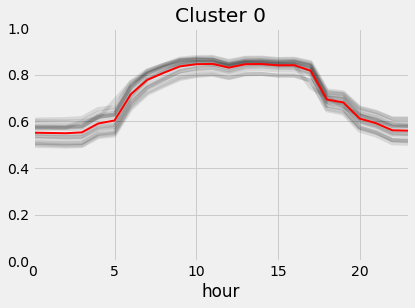

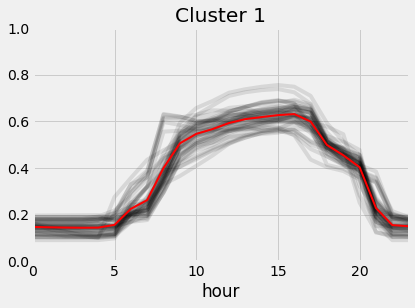

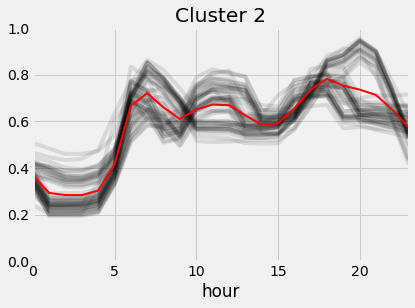

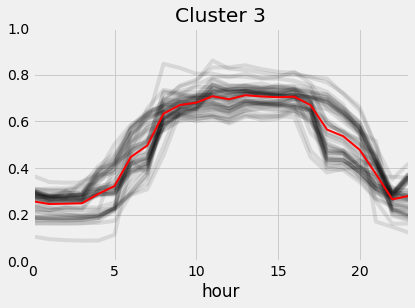

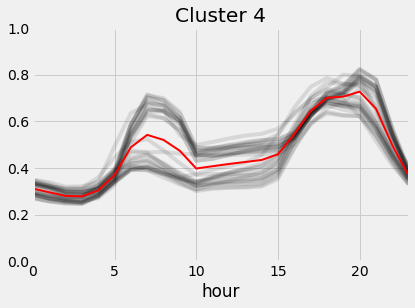

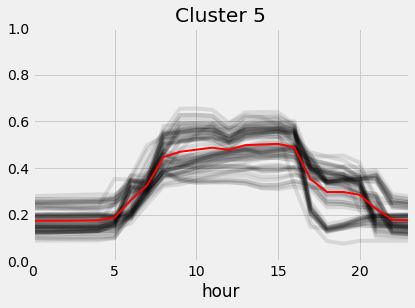

In [70]:
clusters_visualisation(cm_kmeans_df, id_vars = ['type', 'name', 'cluster'], value_vars = list(cm_kmeans_df.columns[3:27]))

The main thing I notice is that now buildings with a launch break (*Warehouse*, *Small/Medium Office*, *PrimarySchool*) are separated from buildings with a 07:00 - 19:00 uniform usage. These, in particular, fall roughly in two categories: (1) those whose consumption increases more slowly in the morning, keeps increasing in the afternoon, and ceases abruptly in the evening (mostly *Malls* and *Retailers*, which probably get more customers in the afternoon than in the morning, when everyone else is also at work); and (2), those whose consumption is distributed somehow simmetrically between mid-day, with an increase in the morning, and a decrease in the afternoon (these are *Supermarkets*, most *LargeOffices*, and the mysterious *OutPatient*).

Furthermore, buildings with a restaurant (*FullServiceRestaurant*, *QuickServiceRestaurant*, and *LargeHotel*) can have either 3 peaks (breakfast, lunch, dinner) or just 2. I suspect this is due to fewer people having lunch at hotels.

Everything else is quite similar to what we noticed before. Whether we are satisfied with the insights we got is a very subjective matter. Certainly different analyses are possible. Some ideas:
* Perform different analyses for working days and weekends/holidays.
* Instead of recording the consumption for each hour, only record three values: -1, meaning that both in the hour before and in the hour after the current one, the consumption was higher; 1, meaning that both in the hour before and in the hour after the current one, the consumption was lower; 0, otherwise. (This will help identify peaks and valleys!)
* Include more features in the clustering algorithm, and verify whether these are sensible choices, or if we end up with the same clusterisation we had when using latitude. Examples: city size, city climate zone, etc.